In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting, functional_models
import subprocess as sp
import os
from scipy.ndimage import interpolation,gaussian_filter,affine_transform
from scipy.ndimage.interpolation import zoom
from scipy.signal import fftconvolve,convolve2d
from matplotlib.colors import LogNorm,Normalize
from photutils import EllipticalAperture,aperture_photometry,\
CircularAperture,EllipticalAnnulus,BoundingBox,ApertureMask
from matplotlib.patches import Rectangle
from matplotlib import rcParams
from astropy import constants
import matplotlib.ticker
from matplotlib.patches import Ellipse
rcParams.update({'figure.autolayout': False})

class FormatScalarFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, fformat="%1.1f", offset=True, mathText=True):
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,
                                                        useMathText=mathText)
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

%matplotlib inline

In [19]:
'''cell for basic reduction steps'''
def imcon(im,r_min,r_max,xc,yc):
    '''returns a mask that selects a donut with inner radius r_min, outer radius r_max, with center xc,yc''' 
    ny, nx = np.shape(im)
    mask = np.zeros((nx,ny),dtype = bool)
    yp, xp = np.mgrid[:ny, :nx]
    yp = yp-yc
    xp = xp-xc
    rmap = np.sqrt(xp**2 + yp**2)
    mask[(rmap <= r_max) * (rmap >= r_min)]= True
    return mask

def centercoro(datacenteruse,dist = False,ampl = False):
    '''determines the center of an individual centerframe, if ampl == True,
    it returns a cube with all the spots of the raw data, which can be used to 
    calculate the wavelength dependend througput'''
    
    centerx,centery = [108,95,175,190],[191,110,95,178] #
    width = 15
    coordinates = np.zeros((4,2))
    data_end = np.zeros((291,291))
    
    rawspots = np.zeros((4,2*width,2*width))
    for i in range(4):
        y, x = np.mgrid[:width*2, :width*2]
        smoothed_center = gaussian_filter(datacenteruse,sigma = 25)
        extracted_smooth = datacenteruse-smoothed_center
        datafirst = extracted_smooth[centerx[i]-width:centerx[i]+width,centery[i]-
                                     width:centery[i]+width]
        maximum = np.unravel_index(datafirst.argmax(), datafirst.shape)
        newcenter = [centerx[i]+maximum[0]-width,centery[i]+maximum[1]-width]
        data = extracted_smooth[newcenter[0]-width:newcenter[0]+width,
                                newcenter[1]-width:newcenter[1]+width]
        rawspots[i] = datacenteruse[newcenter[0]-width:newcenter[0]+width,newcenter[1]-width:newcenter[1]+width]
        p_init = models.Gaussian2D(x_mean = width, y_mean = width, 
                                   x_stddev = 1.5, y_stddev = 1.5)
        fit_p = fitting.LevMarLSQFitter()
        p = fit_p(p_init,x,y, data)
        coordinates[i,0] = p.parameters[1]+newcenter[0]-width
        coordinates[i,1] = p.parameters[2]+newcenter[1]-width
        data_end[centerx[i]-width:centerx[i]+width,centery[i]-width:centery[i]+width]= p(x, y)
    #singleplot(data_end)
    middel = np.mean(coordinates,axis = 0)
    distance1 = np.sqrt(np.sum((coordinates[1,:]-coordinates[3,:])**2))
    distance2 = np.sqrt(np.sum((coordinates[0,:]-coordinates[2,:])**2))
    if dist == True:
        return distance1,distance2
    elif ampl == True:
        return middel[0],middel[1],rawspots
    else:
        return middel[0],middel[1]

def corocentercoordinate(centerdata,ampl=True):
    '''determines the precise center by combining mutiple centering frames, if ampl == True, 
    it returns the median amplitude of the spots in each wavelength, for scaling in the SDI routine'''
    
    coordinates = np.zeros((len(centerdata[:,0,0,0]),39,2))
    mask = imcon(np.zeros((30,30)),0,5,15,15)
    mask = np.ones((4,30,30),dtype = 'int')*mask
    
    if ampl == True:
        spots = np.zeros((len(centerdata[:,0,0,0]),39))
        for data in range(len(centerdata[:,0,0,0])):
            for waveldata in range(len(centerdata[0,:,0,0])):
                coordinates[data,waveldata,0],coordinates[data,waveldata,1],rawspot \
                    = centercoro(centerdata[data,waveldata,:,:],ampl = True)
                spots[data,waveldata] = np.median(rawspot[mask])
        coordinates_mdn = (np.median(coordinates,axis = (0,1)))
        return np.median(spots,axis = 0)
    
    else:
        for data in range(len(centerdata[:,0,0,0])):
                for waveldata in range(len(centerdata[0,:,0,0])):
                    coordinates[data,waveldata,0],coordinates[data,waveldata,1]\
                        = centercoro(centerdata[data,waveldata,:,:])
        coordinates_mdn = (np.median(coordinates,axis = (0,1)))
        return coordinates_mdn[0],coordinates_mdn[1]

def shift_center(data,xcoord,ycoord):
    '''shifts an image from center xcoord,ycoord to the center of the image, 145,145'''
    
    data_shifted = interpolation.shift(data,[145-ycoord,145-xcoord])
    return data_shifted

def noncorocentercoordinate(data,view=20,centx=185,centy=170):
    '''fits a gaussian over non coronografic data and determines the position of the center'''
    
    y, x = np.mgrid[:2*view, :2*view]
    coords = np.zeros((2,len(data[:,0,0])))
    for i in range(len(data[:,0,0])):
        dataatm = data[i,(centx-view):(centx+view),(centy-view):(centy+view)]
        p_init = models.Gaussian2D(x_mean = view, y_mean = view,x_stddev = 2,y_stddev = 2)
        fit_p = fitting.LevMarLSQFitter()
        p = fit_p(p_init, x,y, dataatm)
        coords[0] = p.parameters[1]+centx-view
        coords[1] = p.parameters[2]+centy-view
    coords_med = np.median(coords,axis = 1)
    print(coords_med)
    return coords_med[0],coords_med[1]

def shift_center_all(dataset,flux = False):
    '''centers all data in the cube'''
    
    if flux == False:
        data,he = open_all(dataset = dataset)
        centerdata = open_all(dataset = dataset,cent = True)
        center_y,center_x = corocentercoordinate(centerdata,ampl = False)
    if flux == True:
        data,he = open_all(dataset= dataset,flux = True)
        data = data[0]
        center_y,center_x = noncorocentercoordinate(data)
        
    shifted_data = np.zeros_like(data)
    if flux == False:
        ampls = np.zeros(len(data[:,0,0,0]))
        for i in range(len(data[:,0,0,0])):
            for j in range(39):
                shifted_data[i,j,:,:] = shift_center(data[i,j,:,:],center_x,center_y)
    else:
        for j in range(39):
                shifted_data[j,:,:] = shift_center(data[j,:,:],center_x,center_y)
    return shifted_data,he

In [3]:
'''This cell is for opening and writing of data'''

def positions(width=1,azimuthrange=[-90,270]):
    ell = ellipsemask(width=width,theta = 235,phi = 77,a=1.01,b=0.71)
    x_pos,y_pos = np.where(ell == 1)
    azieangles = azimuthangle(x_pos = x_pos, y_pos = y_pos,newpos=False,azimuthrange = azimuthrange)
    coords = np.array([x_pos,y_pos,azieangles])
    coords = coords[:,coords[2].argsort()]
    aziselect = (coords[2] > azimuthrange[0])*(coords[2] < azimuthrange[1])
    coords = coords[:,aziselect]
    return coords[0],coords[1]

def openshifted():
    RXJ_sh,RXJ_he = shift_center_all(dataset = 'RXJ',coro = True)
    return RXJ_sh,RXJ_he

def open_all(dataset,cent = False, header = False,flux = False):
    if dataset == 'RXJ':
        excludedata = 'sphere_NIRSUR_TYC_7408_0054_1.obx_IFS_SCIENCE_DR.fits'
        excludecenter = 'sphere_NIRSUR_TYC_7408_0054_1.obx_IFS_SCIENCE_DR.fits'
        excludeflux = 'Calibration_IFS_SCIENCE_DR.fits'
        path = '../data/datatouse'
    
    if dataset == 'RXJref':
        path = '../data/reducedRXJref'
        excludedata = 'DR_4.fits'
        excludecenter = 'DR_2.fits'
        excludeflux = 'Calibration_IFS_SCIENCE_DR.fits'
    
    if flux == True:
        path = '%s/flux' %(path)
        flux,flux_he = opendata(path = path, exclude = excludeflux)
        return flux,flux_he
    
    if cent == True:
        path = '%s/starcenter' %(path)
        starcent,starcenthe = opendata(path = path,exclude = excludecenter)
        return starcent
    
    data,he = opendata(path = path,exclude = excludedata)
    if header == True:
        return he
    return data,he

def opendata(path,exclude):
    files,dirs = filenames(path,exclude)
    data_out = np.zeros((len(files[:,0]),39,291,291))
    headers = []
    for i in range(len(files[:,0])):
        data_intermed = np.zeros((len(files[0]),39,291,291))
        for j in range(len(files[0])):
            data, head = fits.getdata('%s/%s/%s' %(path,dirs[i],files[i,j]), header=True)
            data_intermed[j] = data
        data_out[i] = np.median(data_intermed,axis = 0)
        headers.append(head)
    return data_out,headers

def directorynames(path,header = False):        
    all_filenames = os.listdir(path)
    filenames = []
    for i in range(len(all_filenames)):
        if all_filenames[i].startswith('SPHER'):
            filenames.append(all_filenames[i])               
    if header == True:
        header_names = []   
        for j in range(len(filenames)):
            if filenames[j].endswith('000.fits'):
                header_names.append(filenames[j])
        return sorted(header_names)
    else:
        return sorted(filenames)
    
def filenames(path,exclude):
    dirs = directorynames(path)
    all_filenames = []
    for j in range(len(dirs)):
        filenames_all = os.listdir('%s/%s'%(path,dirs[j]))  
        filenames = []
        for i in range(len(filenames_all)):
            if not filenames_all[i].endswith(exclude):
                filenames.append(filenames_all[i])
        all_filenames.append(sorted(filenames))  
    return np.array(all_filenames),dirs

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)

#shifted_flux,he_flux = shift_center_all('RXJ',flux = True)


In [4]:
'''This Cell is for plotting data'''

def singleplot(data,vmin = 0,vmax = 100,name = None,lognorm = False,cutmin = 0,cutmax = 291,\
               save = False, color = 'gist_heat',xc = 145,yc = 145, center = False, interpolation = 'nearest',\
               colorbar = True,radec = False,radecsmall = False,irdis = False):
    '''shows a single 2d image, if center = true, a small circle is added around the center of the image ''' 
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    if lognorm == True:
        norm = LogNorm(vmin = vmin, vmax = vmax)
    else:
        norm = Normalize(vmin = vmin, vmax = vmax)

    im = ax.imshow(data, cmap = color,norm = norm, origin='lower')
    ax.set_ylim(cutmin,cutmax)
    ax.set_xlim(cutmin,cutmax)
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    if center == True: #adds a circle around the center pixel
        circ = plt.Circle((xc,yc),3,fill = False,color = 'white') 
        plt.gca().add_artist(circ)
        
    if radec == True:
        if radecsmall == True:
            if irdis == True:
                ticks = [xc-60,xc-40,xc-20,xc,xc+20,xc+40,xc+60]
            else:
                ticks = [xc - 100,xc-2*33.5,xc-33.5,xc,xc+33.5,xc+67,xc+100]
            ax.set_xticklabels([0.75,0.5,0.25,0,-0.25,-0.5,-0.75])
            ax.set_yticklabels([-0.75,-0.5,-0.25,0,0.25,0.5,0.75])               
        else:
            ticks = [xc-2*67,xc-67,xc,xc+67,xc+2*67]
            ax.set_xticklabels([1,0.50,0,-0.5,-1])
            ax.set_yticklabels([-1,-0.5,0,0.5,1])
        plt.xticks(ticks)
        plt.yticks(ticks)
        ax.set_ylabel(r'$\delta$ DEC (")',fontsize = 25)
        ax.set_xlabel(r'$\delta$ RA (")',fontsize = 25)
    
    #fig.subplots_adjust(wspace=0, hspace=4)#space between subplots
    if colorbar == True:
        cbaxes = fig.add_axes([0.91, 0.125, 0.025, 0.755]) #position and width of the colorbar
        cb = plt.colorbar(im, cax = cbaxes,format = FormatScalarFormatter("%.1f"))
        cb.ax.tick_params(labelsize=25)
        
    if save == True:
        plt.savefig('%s.pdf' %(name),bbox_inches = 'tight',pad_inches = 0.1)

def wavelplot(data,vmax,vmin,save = False,name = None):
    txtcolor = 'yellow'
    txtsize = 13
    ticks = [145-2*67,145-67,145,145+67,145+2*67]
    data_binned,wavels = wavelbinning(13,data)
    data_tot = np.median(data,axis = 0)
    fig, axes = plt.subplots(1, 4,figsize=(16,4),sharex=True, sharey=True)
    for i in range(len(data_binned[:])):
        axes[i].imshow(data_binned[i,:,:],vmax = vmax, vmin = vmin,origin='lower',cmap = 'gist_heat')
        axes[i].text(10,265,r'%s $\mu m$' %(round(wavels[i],2)),color = txtcolor,fontsize=txtsize)
        axes[i].tick_params(axis='both', which='major', labelsize=txtsize)
        axes[i].set_xlabel(r'$\delta$ RA (")',fontsize = txtsize)
    axes[0].set_ylabel(r'$\delta$ DEC (")',fontsize = txtsize)
    axes[3].imshow(data_tot,vmax = vmax, vmin = vmin,origin='lower',cmap = 'gist_heat')
    axes[3].text(10,265,'Entire Y-J range',color = txtcolor,fontsize=txtsize)
    axes[3].tick_params(axis='both', which='major', labelsize=txtsize)
    axes[3].set_xlabel(r'$\delta$ RA (")',fontsize = txtsize)
    plt.xticks(ticks)
    plt.yticks(ticks)
    axes[3].set_xticklabels([1,0.50,0,-0.5,-1])
    axes[3].set_yticklabels([-1,-0.5,0,0.5,1])
    fig.subplots_adjust(wspace=0, hspace=0.2)
    if save==True:
        fig.savefig('%s.pdf' %(name),bbox_inches = 'tight',pad_inches = 0.1)

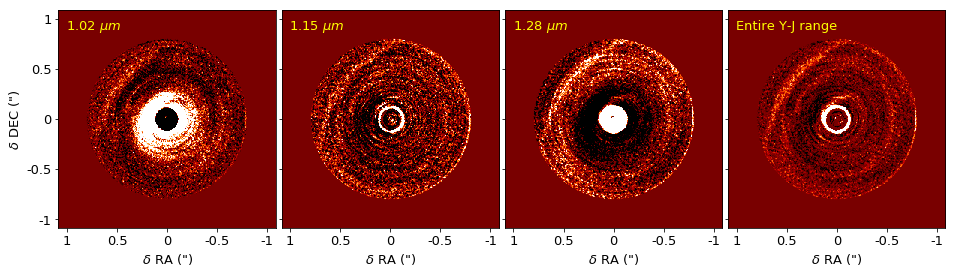

In [255]:
wavelplot(sdi_data_new,1.5,-0.7,name = 'sdi_image_3wavels',save = True)

In [5]:
mod_ADI_cube = fits.getdata('model_adi_cube.fits', header=False)
mod_SDI_cube = fits.getdata('sdi_mod_cube.fits', header=False)
mod_SDI_cube = mod_SDI_cube[:,30:321,30:321]
model = fits.getdata('model.fits', header=False)
data_ADI_cube = fits.getdata('/home/ardjan/Documenten/RXJ1615paper/data/endresults/data_ADI_cube.fits')
data_SDI_cube = fits.getdata('/home/ardjan/Documenten/RXJ1615paper/code/sdi_data_cube.fits')
data_SDI_cube = data_SDI_cube[:,30:321,30:321]
data_RDI_cube = fits.getdata('/home/ardjan/Documenten/RXJ1615paper/data/endresults/data_RDI_cube.fits')
new_sdi_mod = fits.getdata('new_sdi_model.fits')

#sdi_cube_old = fits.getdata('/home/ardjan/Documenten/RXJ1615paper/data/endresults/data_SDI_cube.fits')
#singleplot(mod_ADI_tot,vmax = 3, vmin = -3,radec = True, save = True, name = 'ADImodel')
#singleplot(mod_SDI_tot,vmax = 3, vmin = -3,radec = True, save = True, name = 'SDImodel')

In [18]:
#cell to read in everything

#data_SDI_cube = fits.getdata('../data/endresults/data_SDI_cube.fits', header=False)
#data_SDI_tot = fits.getdata('../data/endresults/data_SDI_tot.fits', header=False)

#data_ADI_cube = fits.getdata('../data/endresults/data_ADI_cube.fits', header=False)
#data_ADI_tot = fits.getdata('../data/endresults/data_ADI_tot.fits', header=False)
#data_RDI_cube = fits.getdata('../data/endresults/data_RDI_cube.fits',header = False)
#data_RDI_tot = fits.getdata('../data/endresults/data_RDI_tot.fits', header = False)


#data_cube_center = fits.getdata('../data/endresults/data_cube_center.fits', header = False)


#data_flux = open_all('RXJref', header = False,flux = True)
#data_flux = data_flux[0]

shiftedflux,fluxhe = shift_center_all('RXJref',flux = True)

data_cube_sh = fits.getdata('../data/endresults/data_cube_sh.fits', header=False)

data_cube_he = open_all('RXJ', header = True)
ref_cube_he = open_all('RXJref', header = True)
ref_cube_sh = fits.getdata('../data/endresults/ref_cube_sh.fits',header = False)

#model_flux = fits.getdata('model_and_psf.fits',header = False)

[184.94964003 169.50582908]
169.50582908333504 184.94964002710222


In [7]:
def azimuthangle(x_pos = 0, y_pos = 0,newpos=True,azimuthrange = [-90,270]):
    if newpos == True:
        x_pos,y_pos = positions(azimuthrange=azimuthrange)
    x_uitw = x_pos-145
    y_uitw = y_pos-145
    azimuthalangle = np.arccos(y_uitw/np.sqrt((y_uitw)**2+(x_uitw)**2))/np.pi*180
    mask_neg = x_uitw < 0
    azimuthalangle[mask_neg] = 360 - azimuthalangle[mask_neg]
    if newpos == True:
        return (azimuthalangle - 90),x_pos,y_pos
    return azimuthalangle - 90

def wavelbinning(binwidth,data,ext = False):
    data_out = np.zeros((int(np.ceil(len(data[:,0,0])/binwidth)),291,291))
    wavels_mid = np.arange(np.ceil(len(data[:,0,0])/binwidth))*np.nan
    wavels = np.linspace(0.953,1.346,39)
    if ext == True:
        wavels = np.linspace(0.953,1.677,39)
    k = 0
    for i in range(0,len(data[:,0,0]),binwidth):
        data_out[k] = np.nanmedian(data[i:i+binwidth],axis = 0)
        wavels_mid[k] = np.nanmean(wavels[i:i+binwidth])
        k += 1
    return data_out,wavels_mid

def aperbinning(binwidth,data,azimuthrange = [-90,270]):
    azimuth,_,_ = azimuthangle(azimuthrange=azimuthrange)
    data_out = np.zeros((int(np.ceil(len(data[0,:])/binwidth)),len(data[:,0])))
    azimuth_mid = np.arange(np.ceil(len(azimuth[:])/binwidth))*np.nan
    k = 0
    for i in range(0,len(data[0,:]),binwidth):
        data_out[k] = np.nanmedian(data[:,i:i+binwidth],axis = 1)
        azimuth_mid[k] = np.nanmean(azimuth[i:i+binwidth])
        k += 1
    return data_out,azimuth_mid

def plotbycolor(data,binwidth_color,binwidth_aprs,r=5,azimuthrange=[-90,270]):
    azimuthalangle,x_pos,y_pos = azimuthangle(newpos=True,azimuthrange=azimuthrange)
    apertures = CircularAperture((y_pos,x_pos),  r = r)
    data,wavels = wavelbinning(binwidth_color,data)
    colorazimut = np.zeros((len(data[:,0,0]),len(x_pos)))
    colorazimut[:,:] = np.nan
    colorbkg = np.zeros((len(data[:,0,0]),len(x_pos)))
    colorbkg[:,:] = np.nan
    for i in range(len(data[:,0,0])):
        azimut = aperture_photometry(data[i], apertures)
        bkg = aperture_photometry(interpolation.rotate(data[i],180), apertures)
        colorazimut[i] = azimut['aperture_sum'] 
        colorbkg[i] = bkg['aperture_sum']
    allvalues,azimuthangle_mid = aperbinning(binwidth_aprs,colorazimut,azimuthrange=azimuthrange)
    allbkg,azimuthangle_mid = aperbinning(binwidth_aprs,colorbkg,azimuthrange=azimuthrange)
    return allvalues,allbkg,wavels,azimuthangle_mid

In [20]:
#cell for everything needed to properly construct a model of the ring in RXJ1615

def ellipsemask(width=1,theta = 0,phi = 90,a=1.05,b=0.71):
    resolution = 1./0.00746
    xc,yc = 145+0.1*resolution,145-0.065*resolution
    a_use,b_use = a*resolution,b*resolution
    #theta,phi = 145,90

    theta = theta * (2*np.pi)/360
    phi = phi  * (2*np.pi)/360
    b_use = b_use*np.sin(phi)

    e = functional_models.Ellipse2D(amplitude = 1, x_0 = xc, y_0 = yc, a = a_use+width/2, b = b_use+width/2, theta = theta)
    e2 = functional_models.Ellipse2D(amplitude = 1, x_0 = xc, y_0 = yc, a = a_use-width/2, b = b_use-width/2, theta = theta)
    y, x = np.mgrid[0:291, 0:291]
    return e(x,y)-e2(x,y)

def positions(width=1,azimuthrange=[-90,270]):
    ell = ellipsemask(width=width,theta = 235,phi = 77,a=1.01,b=0.71)
    x_pos,y_pos = np.where(ell == 1)
    azieangles = azimuthangle(x_pos = x_pos, y_pos = y_pos,newpos=False,azimuthrange = azimuthrange)
    coords = np.array([x_pos,y_pos,azieangles])
    coords = coords[:,coords[2].argsort()]
    aziselect = (coords[2] > azimuthrange[0])*(coords[2] < azimuthrange[1])
    coords = coords[:,aziselect]
    return coords[0],coords[1]

def dummyring(wavelength,datatoconv,widthellipse = 1,theta = 235,phi = 77,a = 1.01,b = 0.71):
    ellipse = ellipsemask(width = widthellipse,theta = theta,phi = phi,a=a,b=b)
    ellipse_convolved = convolve2d(ellipse, datatoconv[wavelength,135:156,135:156] - np.median(datatoconv),\
                                   mode='same', boundary='fill', fillvalue=0)
    ellipse_convolved = np.repeat(ellipse_convolved[None,:,:],39,axis = 0)
    return ellipse_convolved

def modelring():
    model = dummyring(20,datatoconv = shiftedflux,widthellipse = 9,theta = 235,phi = 77,a=1.01,b=0.71)
    allvalues_model,_,_,angles = plotbycolor(model,1,1,r=5,azimuthrange=[-90,270])
    xp, yp = np.mgrid[:291, :291]
    angelies = azimuthangle(x_pos = xp, y_pos = yp,newpos=False)
    angelies = angelies.astype('float128')
    result = np.zeros((291,291),dtype = 'float128')
    p = np.polyfit(angles,allvalues_model[:,3],20)
    for i in range(len(p)):
        if i == 0:
            result += p[0]*angelies**(len(p)-1)
        else:
            result += p[-i]*angelies**(i-1)
    model = model/(result.astype('float64'))*100
    np.nan_to_num(model,0)
    mask_xborder = (xp < yp-50)
    model[:,mask_xborder] = 0
    
    model_rot = np.repeat(model[None,:,:,:],16,axis = 0)
    model_rot = rotate(model_rot,data_cube_he,reverse = True)
    model_def = model_rot+ref_cube_sh
    mask_zero = abs(ref_cube_sh[5,5]) < 0.01
    model_def[:,:,mask_zero] = 0
    model_rot[:,:,mask_zero] = 0
    return model_def,model_rot
model_psf,model_withoutpsf = modelring()

/home/ardjan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


'''
RXJ_SDI,amplitudes = SDI(data_cube_sh,0,39,coro = True,ext = False, dataset = 'RXJ',headers = data_cube_he)
print('SDI is finished')
shiftedcube,headers = openshifted()
RXJ_sh,RXJ_he = openshifted()
RXJ_SDI = SDI(RXJ_sh,0,39,coro = True,ext = False, dataset = 'RXJ',headers = RXJ_he)
print('SDI is finished')
RXJ_ADI = ADI(RXJ_sh,ext = False,headers = RXJ_he)
print('ADI is finished')
ADI_tot = np.median(RXJ_ADI,axis = 0)
SDI_tot = np.median(RXJ_SDI,axis= 0)
return RXJ_SDI,SDI_tot,RXJ_ADI,ADI_tot
'''

In [9]:
'''cell for RDI'''

def RDI():
    RXJ_sh = fits.getdata('../data/endresults/data_cube_sh.fits', header=False)
    RXJ_ref_sh = fits.getdata('../data/endresults/ref_cube_sh.fits',header = False)

    step = 2

    positions = [(145., 145.)]
    RXJ_rot = rotate(RXJ_sh,headers = RXJ_he)
    RXJ_ref_rot =  rotate(RXJ_ref_sh,headers = RXJ_ref_he)
    RXJ_data = np.median(RXJ_rot,axis = 0)
    RXJ_ref_data = np.median(RXJ_ref_rot,axis = 0)

    normingfactors = []

    radii = np.arange(1,110+step,step)

    for j in radii:
        normingfac = []
        for i in range(39):
            mask_non = np.zeros_like(ADI_tot,dtype = 'bool')
            mask_non[:,:] = True
            maskedge = imcon(mask_non,0,265,291,0)
            mask_non[maskedge] = False
            aperture = EllipticalAnnulus(positions,j,j+step,j+step,0)
            #aperture = EllipticalAnnulus(positions,a_in/mag[i],a_out/mag[i],b/mag[i],0)
            normdata = aperture_photometry(RXJ_data[i], aperture, mask = mask_non)
            normref = aperture_photometry(RXJ_ref_data[i], aperture, mask = mask_non)
            normref = normref[0]
            normdata = normdata[0]
            fac = normref['aperture_sum']/normdata['aperture_sum']
            normingfac.append(fac)
            imconmask = imcon(ADI_tot,j,j+step,145,145)
            for l in range(len(RXJ_ref_sh[:,0,0,0])):
                RXJ_ref_sh[l,i,imconmask] = RXJ_ref_sh[l,i,imconmask]/fac
        normingfactors.append(normingfac)

    normingfactors = np.array(normingfactors)
    print(np.shape(normingfactors))

    RXJ_RDI_rot = RXJ_sh - RXJ_ref_sh
    RXJ_RDI = rotate(RXJ_RDI_rot,headers = RXJ_he)
    return RXJ_RDI,normingfactors

In [24]:
'''cell for ADI'''
def maskaononring(rin=30,rout = 100,xcent = 256,ycent=256,size = 512):
    mask_sdi = np.zeros((size,size),dtype = 'bool')
    mask_sdi[:,:] = False
    mask = imcon(np.zeros((size,size)),rin,rout,xcent,ycent)
    mask_sdi[mask]=True
    y,x = np.mgrid[:size,:size]
    maskcorner = y>x+20
    mask_sdi[maskcorner] = False
    return mask_sdi

def rotate(data,headers,reverse = False):
    '''rotates the image with the parallactic angle, which is taken from the header'''
    signal_rotated = np.zeros_like(data)
    sign = -1
    if reverse == True:
        sign = 1
    for file in range(len(data[:,0,0,0])):
        header = headers[file]
        angle = header['HIERARCH ESO TEL PARANG START']
        signal_rotated[file,:,:,:] = interpolation.rotate(data[file,:,:,:],\
                                                sign*(angle+135.99-100.48),reshape = False,axes = (1,2))
    return signal_rotated

def AOnorm(data,r_min,r_max,mag,indiv = False):
    '''corrects for the difference in AO correction between the different cubes, 
    it returns the median of a certain selection of the background, which can be used to equalize the
    brightness of the images'''
    
    norm = np.zeros((len(data[:,0,0,0]),39))
    for j in range(len(data[:,0,0,0])):
        for i in range(39):
            mask = imcon(data[j,i],r_min/mag[i],r_max/mag[i],145, 145)
            norm[j,i] = np.median(data[j,i,mask])
    if indiv == True:
        return norm
    norm = np.median(norm,axis = 1)
    return norm

def ADI(data,headers,ampls = None,ext = False,coro = True,withmodel = False):
    mag = magnification(ext = ext)
    if coro == True:
        norm = AOnorm(data,55,110,mag)
        norm = norm/np.median(norm)
    if coro == False:
        norm = ampls/np.median(ampls)
    data_norm = data/norm[:,None,None,None]
    if withmodel == True:
        data_norm = data_norm + model_withoutpsf
    signal = np.zeros((39,291,291))
    median_bg = np.median(data_norm,axis = 0)
    med_sub = rotate((data_norm-median_bg),headers = headers)
    signal = np.median(med_sub*norm[:,None,None,None],axis = 0)
    return signal


In [25]:
ADI_model = ADI(ref_cube_sh,data_cube_he,withmodel = True)
#singleplot(model_withoutpsf[0,0],vmax = 3)

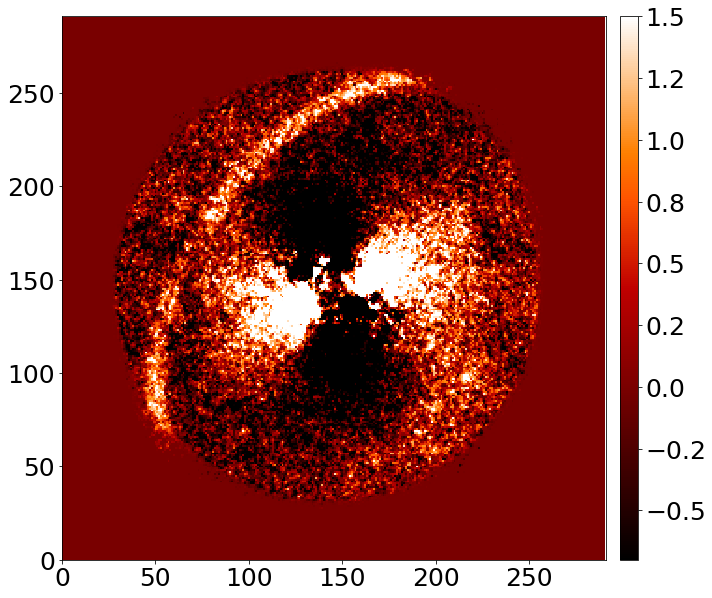

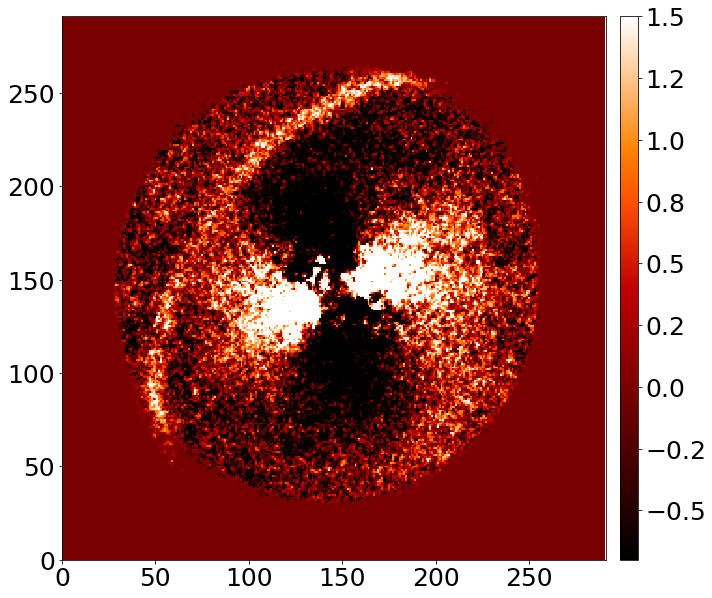

In [38]:
singleplot(np.median(ADI_model[20:25],axis = 0),vmax = 1.5, vmin = -0.7)
singleplot(np.median(ADI_model[27:32],axis = 0),vmax = 1.5, vmin = -0.7)

#singleplot(ADI_data[4],vmax = 1.5, vmin = -0.7)

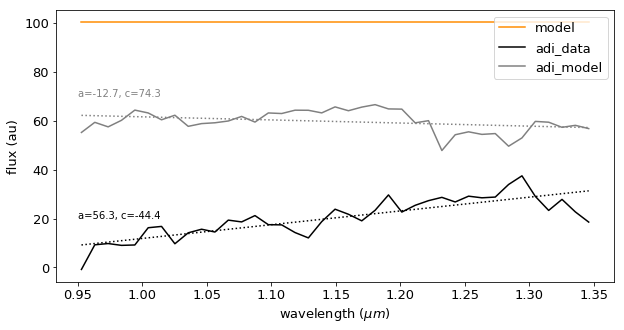

In [244]:
fig, ax = plt.subplots(figsize=(10,5))
adi_data_perwav,_,wavels,_ = plotbycolor(ADI_data,1,281,r=5,azimuthrange = [-15,120])
adi_model_perwav,_,wavels,_ = plotbycolor(ADI_model,1,281,r=5,azimuthrange = [-15,120])
model_ring,_,wavels,_ = plotbycolor(model,1,281,r=5,azimuthrange = [-15,120])

ax.plot(wavels,model_ring[0],color = 'darkorange',label = 'model')
ax.plot(wavels,adi_data_perwav[0],color = 'black',label = 'adi_data')
ax.plot(wavels,adi_model_perwav[0],color = 'grey',label = 'adi_model')

a_mod,c_mod = np.polyfit(wavels,adi_model_perwav[0],deg = 1)
a_data,c_data = np.polyfit(wavels,adi_data_perwav[0],deg = 1)
ax.plot(wavels,wavels*a_mod+c_mod,color = 'grey',linestyle = 'dotted')
ax.plot(wavels,wavels*a_data+c_data,color = 'black',linestyle = 'dotted')
ax.text(.95,20,'a=%s, c=%s' %(round(a_data,1),round(c_data,1)),color = 'black')
ax.text(.95,70,'a=%s, c=%s' %(round(a_mod,1),round(c_mod,1)),color = 'grey')
ax.legend(loc = 'upper right',fontsize = 13)
ax.set_xlabel(r'wavelength ($\mu m$)',fontsize = 13)
ax.set_ylabel('flux (au)',fontsize = 13)
ax.tick_params(axis='both', which='major', labelsize=13)
fig.savefig('adi_slope.pdf',bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

In [11]:
'''cell for SDI'''
def maskaononring(rin=50,rout = 100,xcent = 245,ycent=245,size = 491):
    mask_sdi = np.zeros((size,size),dtype = 'bool')
    mask_sdi[:,:] = False
    mask = imcon(np.zeros((size,size)),rin,rout,xcent,ycent)
    mask_sdi[mask]=True
    y,x = np.mgrid[:size,:size]
    maskcorner = y>x+20
    mask_sdi[maskcorner] = False
    return mask_sdi

def mask_round():
    mag = magnification(ext = False,stop = 39)
    out = np.ones((39,351,351),dtype='bool')
    for i in range(39):
        mask = imcon(out[i],0,107*mag[i],175,175)
        out[i,mask]=False
    return out

def scaling(im, sca, order=2,xcent=145,ycent=145):
    '''scales the image im with given scale sca'''
    
    center = np.array([xcent,ycent])
    if sca == 1:
        return(im)
    scale = np.array([[1./sca,0],[0,1./sca]])
    offset_combined = center - center.dot(scale)
    dst=affine_transform(im,scale.T, order=order, offset=offset_combined, output_shape=(351,351), cval=0.0)
    return(dst)

def descale(imin, scalefac,xcent = 145,ycent=145,order = 2):
    '''scales imin at all wavelengths with their scalefactor scalefac, which is an array'''
    
    nim, nx, ny = imin.shape
    sx = np.ones_like(scalefac) * xcent
    sy = np.ones_like(scalefac) * ycent
    im_out = np.zeros((nim, nx, ny))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = scaling(frame_sq, scalefac[j],xcent=xcent,ycent=ycent,order = order)
        im_out[j,:,:] = frame_rot  
    return(im_out)

def magnification(ext = True,stop = 39,inverse = False):
    if ext == True:
        wavels = np.linspace(0.953,1.677,39)    
    else: 
        wavels = np.linspace(0.953,1.346,39)    
    mag = wavels[stop-1]/wavels
    if inverse == True:
        mag = 1
    return mag

def SDI(data,start,stop,headers,coro = True,ext = False):
    '''Applies SDI on the given data, for the wavelengthrange start to stop.'''
    data_incsz = np.zeros((16,39,351,351))
    data_incsz[:,:,30:321,30:321]=data
    sdi_out = np.zeros((len(data[:,0,0,0]),stop-start,351,351))
    sdi_norm = np.zeros_like(sdi_out)
    descaled = np.zeros_like(sdi_out)
    
    mask = maskaononring(rin=90,rout = 107,xcent = 175,ycent=175,size = 351)
    mag = magnification(ext = ext,stop = stop)
    round_mask = mask_round()
    data = rotate(data_incsz,headers = headers)
    
    for i in range(len(data[:,0,0,0])):
        descaled[i] = descale(data[i,start:stop,:,:], mag[start:stop],xcent=175,ycent=175)
    
    amplitudes = np.median(descaled[:,:,mask],axis = 2)
    amplitudes = amplitudes/np.median(amplitudes)
    sdi_norm = descaled/amplitudes[:,:,None,None]
    
    sdi_norm[:,round_mask]=np.nan
    ref = np.nanmedian(sdi_norm,axis = 1)
    ref = np.nan_to_num(ref,copy = False)
    sdi_norm_sub = sdi_norm - ref[:,None,:,:]
    sdi_norm_sub = np.nan_to_num(sdi_norm_sub,copy = False)
    sdi_norm_sub[:,round_mask]=0
    
    for k in range(len(data[:,0,0,0])):
        sdi_out[k] = descale(sdi_norm_sub[k],1./mag[start:stop],xcent=175,ycent=175)

    sdi_final = sdi_out*amplitudes[:,:,None,None]
    return np.median(sdi_final,axis = 0)

In [ ]:
plt.plot((allvalues_mod[0]+100)/(allvalues_sdi[0]+100))
plt.plot((allvalues_mod_50[0]+100)/(allvalues_sdi[0]+100))

In [ ]:
plt.figure(figsize = (15,10))
allvalues_sdi,allbkg,wavels,azimuthangle_mid_sdi = plotbycolor(data_SDI_cube
                                            ,1,281,r=5,azimuthrange = [-15,120])
allvalues_raw,allbkg,wavels,azimuthangle_mid = plotbycolor(model,1,281,r=5,azimuthrange = [-15,120])
allvalues_old,allbkg,wavels,azimuthangle_mid = plotbycolor(new_sdi_mod[:,30:321,30:321],1,281,r=5,azimuthrange = [-15,120])
allvalues_adi,allbkg,wavels,azimuthangle_mid = plotbycolor(data_ADI_cube,1,281,r=5,azimuthrange = [-15,120])
allvalues_mod,allbkg,wavels,azimuthangle_mid = plotbycolor(mod_SDI_cube,1,281,r=5,azimuthrange = [-15,120])

plt.plot(allvalues_sdi[0,:],color = 'blue',label = 'sdi',linewidth = 3)
plt.plot(allvalues_raw[0,:],color = 'black',label = 'input_model',linewidth = 3)
plt.plot(allvalues_old[0,:],color = 'red',label = 'sdi_new',linewidth = 3)
plt.plot(allvalues_adi[0,:],color = 'grey',label = 'adi',linewidth = 3)
plt.plot(allvalues_mod[0,:],color = 'orange',label = 'sdi_model',linewidth = 3)
plt.plot(withoutnorm[0,:],color = 'green',label = 'withoutnorm', linewidth = 3)
plt.legend(loc = 'best')

#plt.savefig('throughput_over_wavel_everything.pdf')
plt.show()

In [12]:
#unused stuff that might be usefull later

def maskedge(mag=1):
    size = 291
    y,x = np.mgrid[:size,:size]
    mask_fin = np.zeros((size,size),dtype = 'bool')
    mask_upper = y>x/9+130+100*mag
    mask_lower = y<x/9+130-100*mag
    mask_left = x<(y/(-6))+170-110*mag
    mask_right = x>(y/(-6))+170+110*mag
    mask_fin[mask_left+mask_right+mask_upper+mask_lower] = True
    return mask_fin

def showmodel():
    model = dummyring(20,widthellipse = 9,theta = 235,phi = 77,a=1.01,b=0.71)
    allvalues_model,_,_,angles = plotbycolor(model,1,1,r=5)
    plt.figure(figsize=(14,10))
    plt.scatter(angles,allvalues_model[:,3])#,s=4)
    p = np.polyfit(angles,allvalues_model[:,3],50)
    dummy_angle=np.arange(-40,140)
    dummy_angle=dummy_angle.astype('float128')
    model_facs = 0
    for i in range(len(p)):
        if i == 0:
            model_facs += p[0]*dummy_angle**(len(p)-1)
        else:
            model_facs += p[-i]*dummy_angle**(i-1)
    plt.plot(dummy_angle,model_facs)
    ##plt.ylim(8,20)
    plt.xlim(-40,140)
    plt.ylabel('flux')
    plt.xlabel('azimuthal angle')
    #plt.savefig('fluxvsangle.pdf')

def bende():
    singleplot(model[3],vmin = 95, vmax = 125)

    allvalues_2ndmodel,_,_,angles2nd = plotbycolor(model,1,10,start = 0,\
                                             stop = 1915, skip = 1,width = 1,r=5,make_mask=False)
    plt.figure(figsize=(14,10))
    plt.scatter(angles2nd,allvalues_2ndmodel[:,3])
    plt.ylabel('flux')
    plt.xlabel('azimuthalangle')
    plt.savefig('residuals.png')
                                                   
def dummyring_allcol(wavelength,stop,datatoconv,widthellipse = 1,theta = 0,phi = 90,a = 1.05,b = 0.71,\
              make_mask=False):
    ellipse_convolved = np.zeros((39,291,291))
    normalized_ellipse = np.zeros((39,291,291))
    ellipse = ellipsemask(width = widthellipse,theta = theta,phi = phi,a=a,b=b)
    x_pos,y_pos,stop = positions(0,stop,1,width = 7,makestop = True)
    for i in range(39):
        ellipse_convolved[i] = convolve2d(ellipse, datatoconv[i,135:156,135:156] - \
                                    np.median(datatoconv[i]),mode='same', boundary='fill', fillvalue=0)
    allvalues1,_,_,_ = plotbycolor(ellipse_convolved,1,1,start = 0,stop = stop, skip = 1,width = 7,r=3,\
                                   make_mask=make_mask)
    factors = np.median(allvalues1)/allvalues1
    medianfac = np.median(allvalues1,axis = 0)
    ellipse_convolved/medianfac[:,None,None]
    for i in range(39):
        normalized_ellipse[i,x_pos,y_pos] = 1-(1-factors[:,i])*1.1
        normalized_ellipse[i] = convolve2d(normalized_ellipse[i], datatoconv[i,135:156,135:156] - \
                                    np.median(datatoconv[i]),mode='same', boundary='fill', fillvalue=0)
    return normalized_ellipse,ellipse_convolved

def maskedge(mag=1):
    size = 291
    y,x = np.mgrid[:size,:size]
    mask_fin = np.zeros((size,size),dtype = 'bool')
    mask_upper = y>x/9+130+100*mag
    mask_lower = y<x/9+130-80*mag
    mask_left = x<(y/(-6))+170-100*mag
    mask_right = x>(y/(-6))+170+110*mag
    mask_fin[mask_left+mask_right+mask_upper+mask_lower] = True
    return mask_fin

def allmasks():
    mag = magnification(ext = False,stop = 39)
    masks = np.zeros((39,291,291),dtype='bool')
    for i in range(39):
        masks[i]=maskedge(mag[i])
    return masks

#    return good_ellipse_convolved,ellipse_convolved,good_ellipse,ellipse
#ring_dummy_2,ring_dummy_1,good_ellipse,ellipse = dummyring(20,stop = 1900,widthellipse = 7,theta = 235,phi = 77,a=1.01,b=0.71)
#normalized_ellipse,ellipse_convolved = dummyring(20,stop = 1915,widthellipse = 7,theta = 235,phi = 77,\
#                                                 a=1.01,b=0.71)

#data,binwidth_color,binwidth_aprs,start=0,stop=220,skip=1,width=1                                                   

In [ ]:
data_incsz = np.zeros((16,39,351,351))
data_incsz[:,:,30:321,30:321]=model
mag = magnification(ext = False,stop = 38)
for i in range(16):
    data_incsz[i] = descale(data_incsz[i,:,:,:], mag, xcent=175,ycent=175)
wfits(data_incsz,'model_allwavel_scaled.fits')

In [104]:
def singlesdi(data,mag,mask,round_mask,mask_outedge,model,amplitudes,withmodel = False,old_outcome=np.zeros((39,351,351))):
    data_incsz = np.zeros((39,351,351))
    data_incsz[:,30:321,30:321]=data
    descaled = descale(data_incsz, mag,xcent=175,ycent=175)
    #amplitudes = np.median(descaled[:,mask],axis = 1)
    #amplitudes = amplitudes/np.mean(amplitudes)
    descaled = descaled/amplitudes[:,None,None]
    if withmodel == True:
        grey_norm = descaled + model
    else:
        grey_norm = descaled
        
    grey_norm[round_mask]=np.nan
    grey_norm[[0,38]]=np.nan
    grey_norm[:,mask_outedge]=0
    
    ref = np.nanmedian(grey_norm-old_outcome,axis = 0)
    stack = grey_norm - ref
    stack = np.nan_to_num(stack)
    
    imout = descale(stack,1./mag,xcent=175,ycent=175)
    imout = imout*amplitudes[:,None,None]
    #stack = stack*amplitudes[:,None,None]
    return imout#,stack
        
def allsdi(data,ampls,number_iter = 1,withmodel = False,rotate_180 = False):   
    
    data = rotate(data,headers = data_cube_he)
    
    if rotate_180 == True:
        data = interpolation.rotate(data,180,reshape = False,axes = (2,3))
    
    mag = magnification(ext = False,stop = 39)
    mask = maskaononring(rin=30,rout = 75,xcent = 175,ycent=175,size = 351)
    round_mask = mask_round()
    mask_outedge = imcon(np.zeros((351,351)),107*mag[0],600,175,175)
    model = fits.getdata('model.fits')
    model = np.nan_to_num(model,copy = False)
    model_in = np.zeros((39,351,351))
    model_in[:,30:321,30:321]=model
    model_in = descale(model_in,mag,xcent=175,ycent=175)
    #old_outcome = np.zeros((39,351,351))
    all_models = np.zeros((number_iter,39,351,351))
    final_outcome = np.zeros((number_iter,39,291,291))
    #zoomed_outcome = np.zeros((16,39,351,351))
    
    for k in range(number_iter):
        out_all = np.zeros((16,39,351,351))
        for i in range(16):
            norm = AOnorm(data,55,110,mag)
            norm = norm/np.median(norm)
            data_norm = data/norm[:,None,None,None]
            #zoomed_outcome[i],
            out_all[i]=singlesdi(data_norm[i],mag,mask,round_mask,mask_outedge,model_in,ampls,withmodel = withmodel\
                                )#,old_outcome=old_outcome)
            out_all=out_all*norm[:,None,None,None]
        #old_outcome = np.median(zoomed_outcome,axis = (0,1))
        #noises = np.std(old_outcome[mask])
        #old_outcome[old_outcome<noises]=0
        #all_models[k]=old_outcome
        final_outcome[k] = np.median(out_all[:,:,30:321,30:321],axis = 0)
    return final_outcome

In [219]:
sdi_model=allsdi(ref_cube_sh,ampls_model,1,withmodel = True,rotate_180 = False)
#sdi_data_new=allsdi(data_cube_sh,ampls_data*ampls_model/ampls_model_new,1,withmodel = False,rotate_180 = False)

/home/ardjan/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [222]:
sdi_model = sdi_model[0]
#sdi_data_new = sdi_data_new[0]

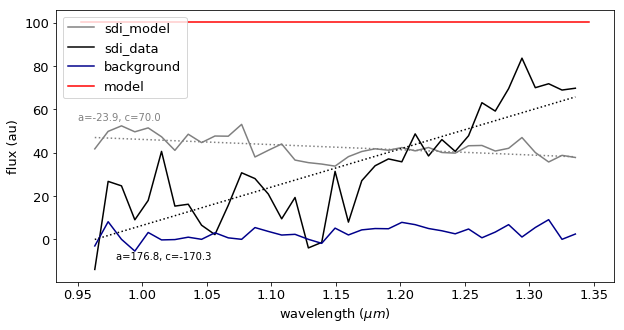

In [253]:
#datarot_mod = interpolation.rotate(sdi_model,180,reshape = False,axes = (1,2))
datarot = interpolation.rotate(sdi_data,180,reshape = False,axes = (1,2))
sdi_model_perwav,_,wavels,_ = plotbycolor(sdi_model,1,281,r=5,azimuthrange = [-15,120])
#sdi_model_bkg,_,wavels,_ = plotbycolor(sdi_model_0,1,281,r=5,azimuthrange = [-15,120])
#sdi_model_rot,_,wavels,_ = plotbycolor(datarot_mod,1,281,r=5,azimuthrange = [-15,120])
#sdi_data_perwav,_,wavels,_ = plotbycolor(sdi_data,1,281,r=5,azimuthrange = [-15,120])
sdi_data_perwav_new,_,wavels,_ = plotbycolor(sdi_data_new,1,281,r=5,azimuthrange = [-15,120])
sdi_data_bkg_new,_,wavels,_ = plotbycolor(datarot,1,281,r=5,azimuthrange = [-15,120])


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(wavels[1:38],sdi_model_perwav[0,1:38],color = 'grey',label = 'sdi_model')
#ax.plot(wavels[1:38],sdi_model_bkg[0,1:38],color = 'darkblue',label = 'background')
#ax.plot(range(1,38),sdi_data_perwav[0,1:38],color = 'black')
#ax.plot(range(1,38),sdi_model_rot[0,1:38],color = 'grey',linestyle = 'dotted')
ax.plot(wavels[1:38],sdi_data_perwav_new[0,1:38],color = 'black',label = 'sdi_data')
ax.plot(wavels[1:38],sdi_data_bkg_new[0,1:38],color = 'darkblue',label = 'background')


a_mod_sdi,c_mod_sdi = np.polyfit(wavels[1:38],sdi_model_perwav[0,1:38],deg = 1)
a_data_sdi,c_data_sdi = np.polyfit(wavels[1:38],sdi_data_perwav_new[0,1:38],deg = 1)
ax.plot(wavels[1:38],wavels[1:38]*a_data_sdi+c_data_sdi,color = 'black', linestyle = 'dotted')
ax.plot(wavels[1:38],wavels[1:38]*a_mod_sdi+c_mod_sdi,color = 'grey',linestyle = 'dotted')


model_ring,_,wavels,_ = plotbycolor(model,1,281,r=5,azimuthrange = [-15,120])
ax.plot(wavels,model_ring[0],color = 'red',label = 'model')
ax.legend(loc = 'upper left',fontsize = 13)


#ax.set_xticks(range(39), minor=True)
#ax.set_xticks(range(0,40,5))
#ax.set_yticks(range(-30,100),minor = True)

ax.text(.98,-9,'a=%s, c=%s' %(round(a_data_sdi,1),round(c_data_sdi,1)),color = 'black')
ax.text(.95,55,'a=%s, c=%s' %(round(a_mod_sdi,1),round(c_mod_sdi,1)),color = 'grey')

ax.set_xlabel(r'wavelength ($\mu m$)',fontsize = 13)
ax.set_ylabel('flux (au)',fontsize = 13)
ax.tick_params(axis='both', which='major', labelsize=13)
fig.savefig('sdi_slope.pdf',bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

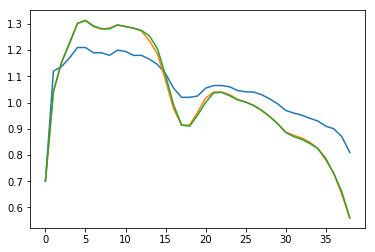

In [249]:
plt.plot(ampls_data)
plt.plot(ampls_model)
plt.plot(ampls_model_new)

NameError: name 'sdi_model_1iter' is not defined

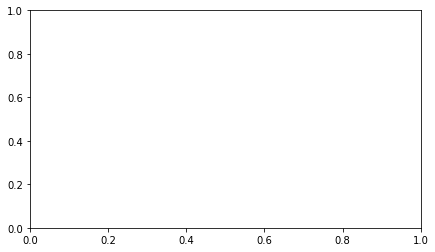

In [218]:
#this one is corrected for rotation
ampls_model_new = np.array([
0.7, 1.042, 1.152, 1.227, 1.302, 1.314,
1.292, 1.282, 1.281, 1.296, 1.29,
1.284,1.275, 1.254, 1.204, 1.104,
0.992, 0.914,0.910, 0.952, 1.0,
1.037, 1.039, 1.026, 1.010, 1.002,
0.989, 0.97, 0.947, 0.919,0.886,
0.87, 0.86, 0.844, 0.825, 0.787,
0.73, 0.66, 0.56])

#this one is measured at the same place as the ring
ampls_model = np.array([
0.7, 1.042, 1.152, 1.224, 1.302, 1.312,
1.290, 1.28, 1.284, 1.296, 1.29,
1.284,1.273, 1.235, 1.185, 1.084,
0.977, 0.914,0.914, 0.963, 1.017,
1.040, 1.040, 1.030, 1.012, 1.002,
0.989, 0.97, 0.947, 0.919,0.888,
0.875, 0.865, 0.849, 0.825, 0.781,
0.73, 0.65, 0.56])

ampls_data = np.array([
0.7, 1.12, 1.137, 1.17, 1.21, 1.21,
1.19, 1.19, 1.18, 1.2, 1.195,
1.18,1.18, 1.165, 1.145, 1.11,
1.055, 1.02,1.02, 1.025, 1.055,
1.065, 1.065, 1.06, 1.046, 1.041,
1.04, 1.03, 1.014, 0.995,0.97,
0.96, 0.952, 0.94, 0.93, 0.91,
0.9, 0.87, 0.81])


fig, ax = plt.subplots(figsize=(7,4))
data_perwav_model_1,_,wavels_3,_ = plotbycolor(sdi_model_1iter[0],1,281,r=5,azimuthrange = [-15,120])
#data_perwav_data,_,wavels,_ = plotbycolor(sdi_data_1iter_withoutmod[0],1,281,r=5,azimuthrange = [-5,110])

ax.plot(data_perwav_9[0],color = 'grey')
ax.plot(data_perwav_model_3[0],color = 'orange')
ax.plot(data_perwav_model_1[0],color = 'green')
#ax.plot(data_perwav_model_2[0],color = 'red')
#ax.plot(data_perwav_data[0],color = 'red')

ax.set_xticks(range(39), minor=True)
ax.set_xticks(range(0,40,5))
#ax.set_yticks(range(-30,100),minor = True)

ax.grid(which='both')
ax.grid(which='minor', alpha=0.8)
ax.grid(which='major', alpha=1)

In [12]:
dat = np.zeros((39,351,351))
dat[:,30:321,30:321] = sdi_mod_1iter
mask = maskaononring(rin=35,rout = 107,xcent = 175,ycent=175,size = 351)
noises = np.std(dat[:,mask],axis = 1)
dat[dat<noises[:,None,None]*3]=0
singleplot(dat[5],vmax = 2,vmin = -1,cutmax = 351)

print(noises)

NameError: name 'sdi_mod_1iter' is not defined

In [ ]:
def modelsdi(data,model,headers,ext = False,start = 0, stop = 39):
    '''Applies SDI on the model, for the wavelengthrange start to stop.'''
    
    data_incsz = np.zeros((2,16,39,351,351))
    data_incsz[0,:,:,30:321,30:321]=data
    data_incsz[1,:,:,30:321,30:321]=model
    data_incsz = np.nan_to_num(data_incsz,copy = False)
    sdi_out = np.zeros((len(data[:,0,0,0]),stop-start,351,351))
    descaled = np.zeros_like(data_incsz)
    
    mask = maskaononring(rin=90,rout = 107,xcent = 175,ycent=175,size = 351)
    mag = magnification(ext = ext,stop = stop)
    round_mask = mask_round()
    data_incsz[0] = rotate(data_incsz[0],headers = headers)
    
    for j in range(2):
        for i in range(len(data[:,0,0,0])):
            descaled[j,i] = descale(data_incsz[j,i,start:stop,:,:], mag[start:stop],xcent=175,ycent=175)
    print(descaled.shape)
    amplitudes = np.median(descaled[:,:,:,mask],axis = 3)
    amplitudes = amplitudes[0]/np.median(amplitudes[0])
    print(amplitudes.shape)
    descaled[0] = descaled[0]/amplitudes[:,:,None,None]
    grey_norm = np.sum(descaled,axis = 0)
    print(grey_norm.shape)
    grey_norm[:,round_mask]=np.nan
    
    ref = np.nanmedian(grey_norm,axis = 1)
    ref = np.nan_to_num(ref,copy = False)
    sdi_norm_sub = grey_norm - ref[:,None,:,:]
    sdi_norm_sub = np.nan_to_num(sdi_norm_sub,copy = False)
    sdi_norm_sub[:,round_mask]=0
    
    for k in range(len(data[:,0,0,0])):
        sdi_out[k] = descale(sdi_norm_sub[k],1./mag[start:stop],xcent=175,ycent=175)

    sdi_final = sdi_out*amplitudes[:,:,None,None]
    return np.median(sdi_final,axis = 0),amplitudes,grey_norm,data_incsz,ref,round_mask

In [ ]:
ampls = sdi_model_cube[1]
ampls_mean = np.median(ampls,axis = 0)
plt.plot(ampls_mean)
wfits(ampls_mean,'ampls_mean.fits')

In [ ]:
#modeldef,model = modelring()
#print(np.shape(model))
plt.figure(figsize = (15,10))
allvalues_sdi_mod,allbkg,wavels,azimuthangle_mid = plotbycolor(new_sdi_mod[:,30:321,30:321],39,3,r=5,azimuthrange = [-15,120])
allvalues_adi_mod,allbkg,wavels,azimuthangle_mid = plotbycolor(mod_ADI_cube,39,3,r=5,azimuthrange = [-15,120])
allvalues_raw,allbkg,wavels,azimuthangle_mid = plotbycolor(model,39,3,r=5,azimuthrange = [-15,120])

allvalues_sdi,allbkg,wavels,azimuthangle_mid = plotbycolor(data_SDI_cube,39,3,r=5,azimuthrange = [-15,120])
allvalues_adi,allbkg,wavels,azimuthangle_mid = plotbycolor(data_ADI_cube,39,3,r=5,azimuthrange = [-15,120])
allvalues_rdi,allbkg,wavels,azimuthangle_mid = plotbycolor(data_RDI_cube,39,3,r=5,azimuthrange = [-15,120])

plt.plot(azimuthangle_mid,allvalues_sdi_mod[:,0],color = 'blue',label = 'sdi_mod',linewidth = 3)
plt.plot(azimuthangle_mid,allvalues_adi_mod[:,0],color = 'red',label = 'adi_mod',linewidth = 3)
plt.plot(azimuthangle_mid,allvalues_raw[:,0],color = 'black',label = 'raw_mod',linewidth = 3)

plt.plot(azimuthangle_mid,allvalues_sdi[:,0],color = 'green',label = 'sdi',linewidth = 3)
plt.plot(azimuthangle_mid,allvalues_adi[:,0],color = 'orange',label = 'adi',linewidth = 3)
plt.plot(azimuthangle_mid,allvalues_rdi[:,0],color = 'purple',label = 'rdi',linewidth = 3)

plt.legend(loc = 'upper right')
plt.ylim(0,120)
plt.xlim(-20,120)
#plt.savefig('modelvalues_corsdi.pdf')

In [41]:
def fluxinr(data,rmin=0,rmax=107,step = 2,center = [175,175]):
    radii = np.arange(rmin,rmax,step)
    if step > 1:
        radii_mid = np.arange(rmin+step/2,rmax+step/2,step)
    else:
        radii_mid = radii
    mask_non = np.ones_like(data,dtype = 'bool')
    nx, ny = data.shape
    y,x = np.mgrid[:nx,:ny]
    mask_non[y<x] = False
    out_val = []
    #fig,ax = plt.subplots(1,1,figsize = (10,10))
    #ax.imshow(grey_norm[38])
    for j in radii:
        aperture = EllipticalAnnulus(center,j,j+step,j+step)
        #aperture.plot()
        ap_phot = aperture_photometry(data, aperture, mask = mask_non)
        out_val.append(ap_phot['aperture_sum'])
    out_val = np.array(out_val)
    return out_val[:,0],radii

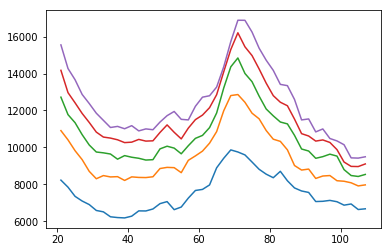

In [197]:
for i in range(5):
    r_flux,rads = fluxinr(ref_cube_sh[2,i],rmin = 20)
    plt.plot(rads,r_flux)

In [16]:
data = data_cube_sh
data = rotate(data,headers = data_cube_he)
mag = magnification(ext = False,stop = 39)
mask = maskaononring(rin=30,rout = 75,xcent = 175,ycent=175,size = 351)
round_mask = mask_round()
mask_outedge = imcon(np.zeros((351,351)),107*mag[0],1000,175,175)
#model = fits.getdata('model.fits')
#model = np.nan_to_num(model,copy = False)
#model_in = np.zeros((39,351,351))
#model_in[:,30:321,30:321]=model
#model_in = descale(model_in,mag,xcent=175,ycent=175)

data_incsz = np.zeros((39,351,351))
data_incsz[:,30:321,30:321]=data[1]
descaled = descale(data_incsz,mag,xcent=175,ycent=175)
amplitudes = np.median(descaled[:,mask],axis = 1)
amplitudes2 = amplitudes/np.median(amplitudes)
descaled = descaled

grey_norm = descaled/amplitudes2[:,None,None]# + model_in
grey_norm[round_mask]=np.nan
grey_norm[:,mask_outedge]=0
#grey_norm[[0,1,2,36,37,38],:,:]=np.nan

ref = np.nanmedian(grey_norm,axis = 0)
sdi_norm_sub = grey_norm - ref
sdi_norm_sub = np.nan_to_num(sdi_norm_sub)

sdi_out = descale(sdi_norm_sub,1./mag,xcent=175,ycent=175)

sdi_out = sdi_out[:,30:321,30:321]*amplitudes2[:,None,None]

In [101]:
allvalues_grey0 = np.zeros((2,39,90))
grey_norm = np.nan_to_num(grey_norm)
#grey_norm[round_mask]= 0
#r_flux,rads = fluxinr(sdi_out[0],rmin = 20,rmax = 200,center = [145,145])
#plt.plot(rads,r_flux)

for i in range(0,39,1):
    allvalues_grey0[0,i],allvalues_grey0[1,i] = fluxinr(grey_norm[i],rmin = 20,rmax = 200,center = [175,175])

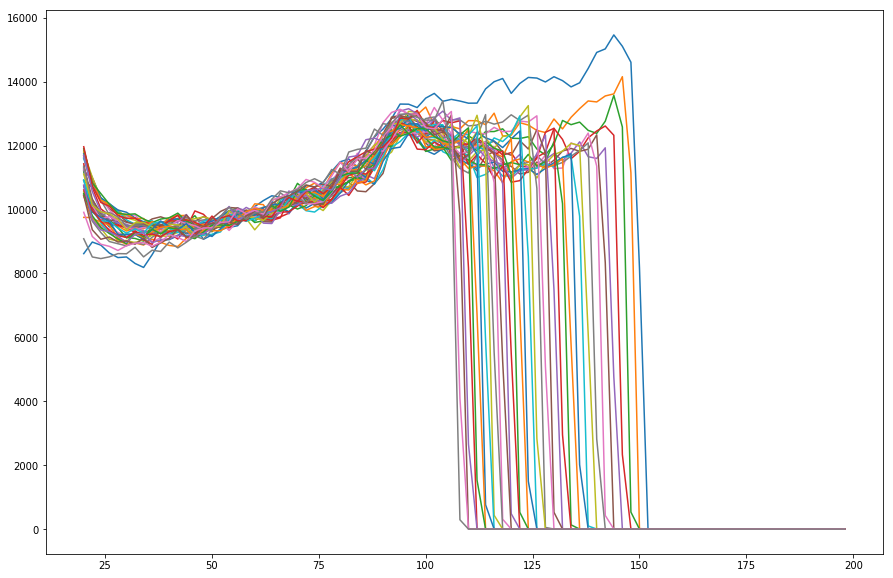

'\nplt.figure()\nr_flux,rads = fluxinr(sdi_mod_1iter[15],rmin = 20,rmax = 200,center = [145,145],step = 2)\nplt.plot(rads,r_flux)\nplt.show()\n'

In [102]:
plt.figure(figsize = (15,10))
for i in range(0,38,1):
    plt.plot(allvalues_grey0[1,i,:],allvalues_grey0[0,i,:])
#plt.ylim(5000,25000)
plt.savefig('grey0_out.png')
plt.show()

#-np.nanmedian(allvalues[0],axis = 0)
#print(allvalues[:,38])

'''
plt.figure()
r_flux,rads = fluxinr(sdi_mod_1iter[15],rmin = 20,rmax = 200,center = [145,145],step = 2)
plt.plot(rads,r_flux)
plt.show()
'''
#sdi_mod_1iter
#[0,1,2,36,37,38]


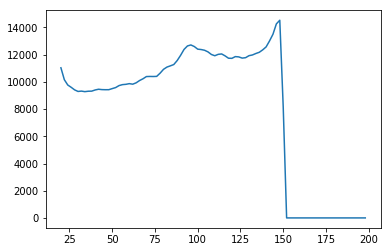

In [103]:
r_flux,rads = fluxinr(ref,rmin = 20,rmax = 200,center = [175,175])
plt.plot(rads,r_flux)
plt.savefig('ref.png')
plt.show()

In [105]:
np.nan -np.nan

nan

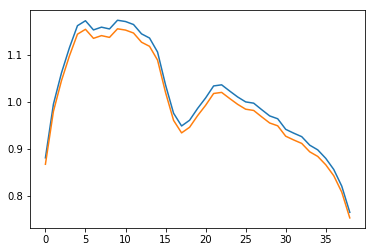

In [20]:
plt.plot(amplitudes/np.median(amplitudes))
plt.plot(amplitudes/np.mean(amplitudes))

In [ ]:
ampls_model = np.array([
0.7, 0.9, 1.0, 1.231, 1.31, 1.317,
1.295, 1.28, 1.284, 1.296, 1.29,
1.284,1.276, 1.239, 1.185, 1.084,
0.977, 0.912,0.912, 0.963, 1.017,
1.040, 1.040, 1.030, 1.012, 1.002,
0.989, 0.967, 0.947, 0.919,0.888,
0.875, 0.865, 0.849, 0.825, 0.781,
0.74, 0.66, 0.56])